In [176]:
import pandas as pd
import numpy as np
import seaborn as sns

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

In [178]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [179]:
df=pd.read_csv("data/NSE-Tata.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [180]:
df.index

RangeIndex(start=0, stop=1235, step=1)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1235 non-null   object 
 1   Open                  1235 non-null   float64
 2   High                  1235 non-null   float64
 3   Low                   1235 non-null   float64
 4   Last                  1235 non-null   float64
 5   Close                 1235 non-null   float64
 6   Total Trade Quantity  1235 non-null   float64
 7   Turnover (Lacs)       1235 non-null   float64
dtypes: float64(7), object(1)
memory usage: 77.3+ KB


In [183]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03,1235.000000
mean,168.954858,171.429069,166.402308,168.736356,168.731053,2.604151e+06,4843.166502
std,51.499145,52.436761,50.542919,51.587384,51.544928,2.277028e+06,5348.919832
min,103.000000,104.600000,100.000000,102.600000,102.650000,1.001800e+05,128.040000
25%,137.550000,138.925000,135.250000,137.175000,137.225000,1.284482e+06,1801.035000
50%,151.500000,153.250000,149.500000,151.200000,151.100000,1.964885e+06,3068.510000
75%,169.000000,172.325000,166.700000,169.100000,169.500000,3.095788e+06,5852.600000
max,327.700000,328.750000,321.650000,325.950000,325.750000,2.919102e+07,55755.080000


In [184]:
df.dtypes

Date                     object
Open                    float64
High                    float64
Low                     float64
Last                    float64
Close                   float64
Total Trade Quantity    float64
Turnover (Lacs)         float64
dtype: object

<Axes: >

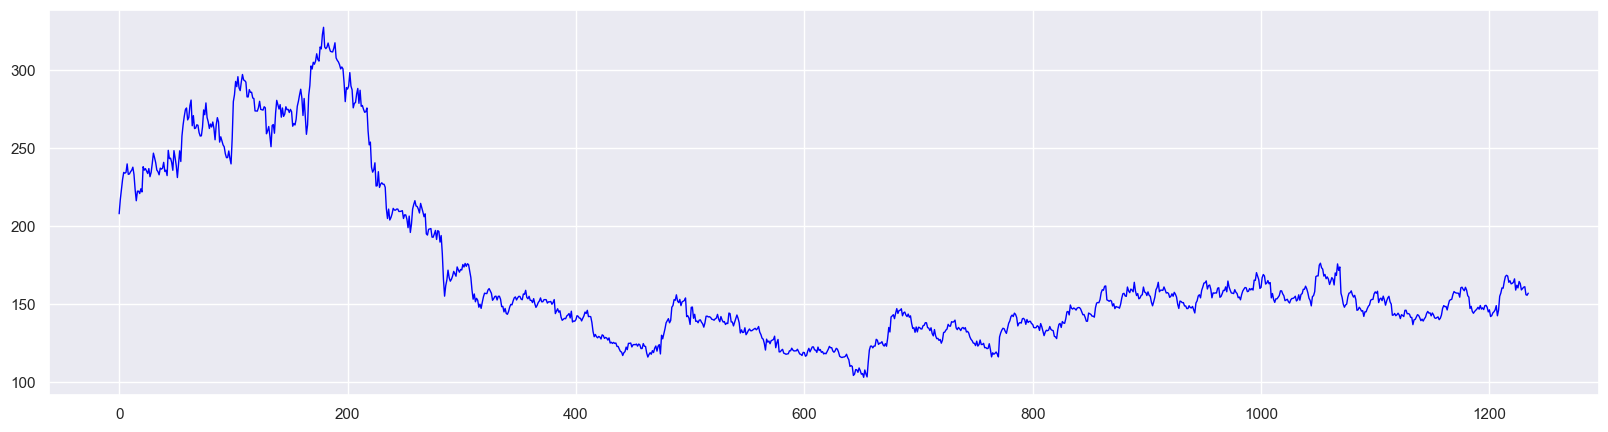

In [185]:
sns.set(rc={'figure.figsize' :(20,5)})
df['Open'].plot(linewidth=1,color='blue')

In [186]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

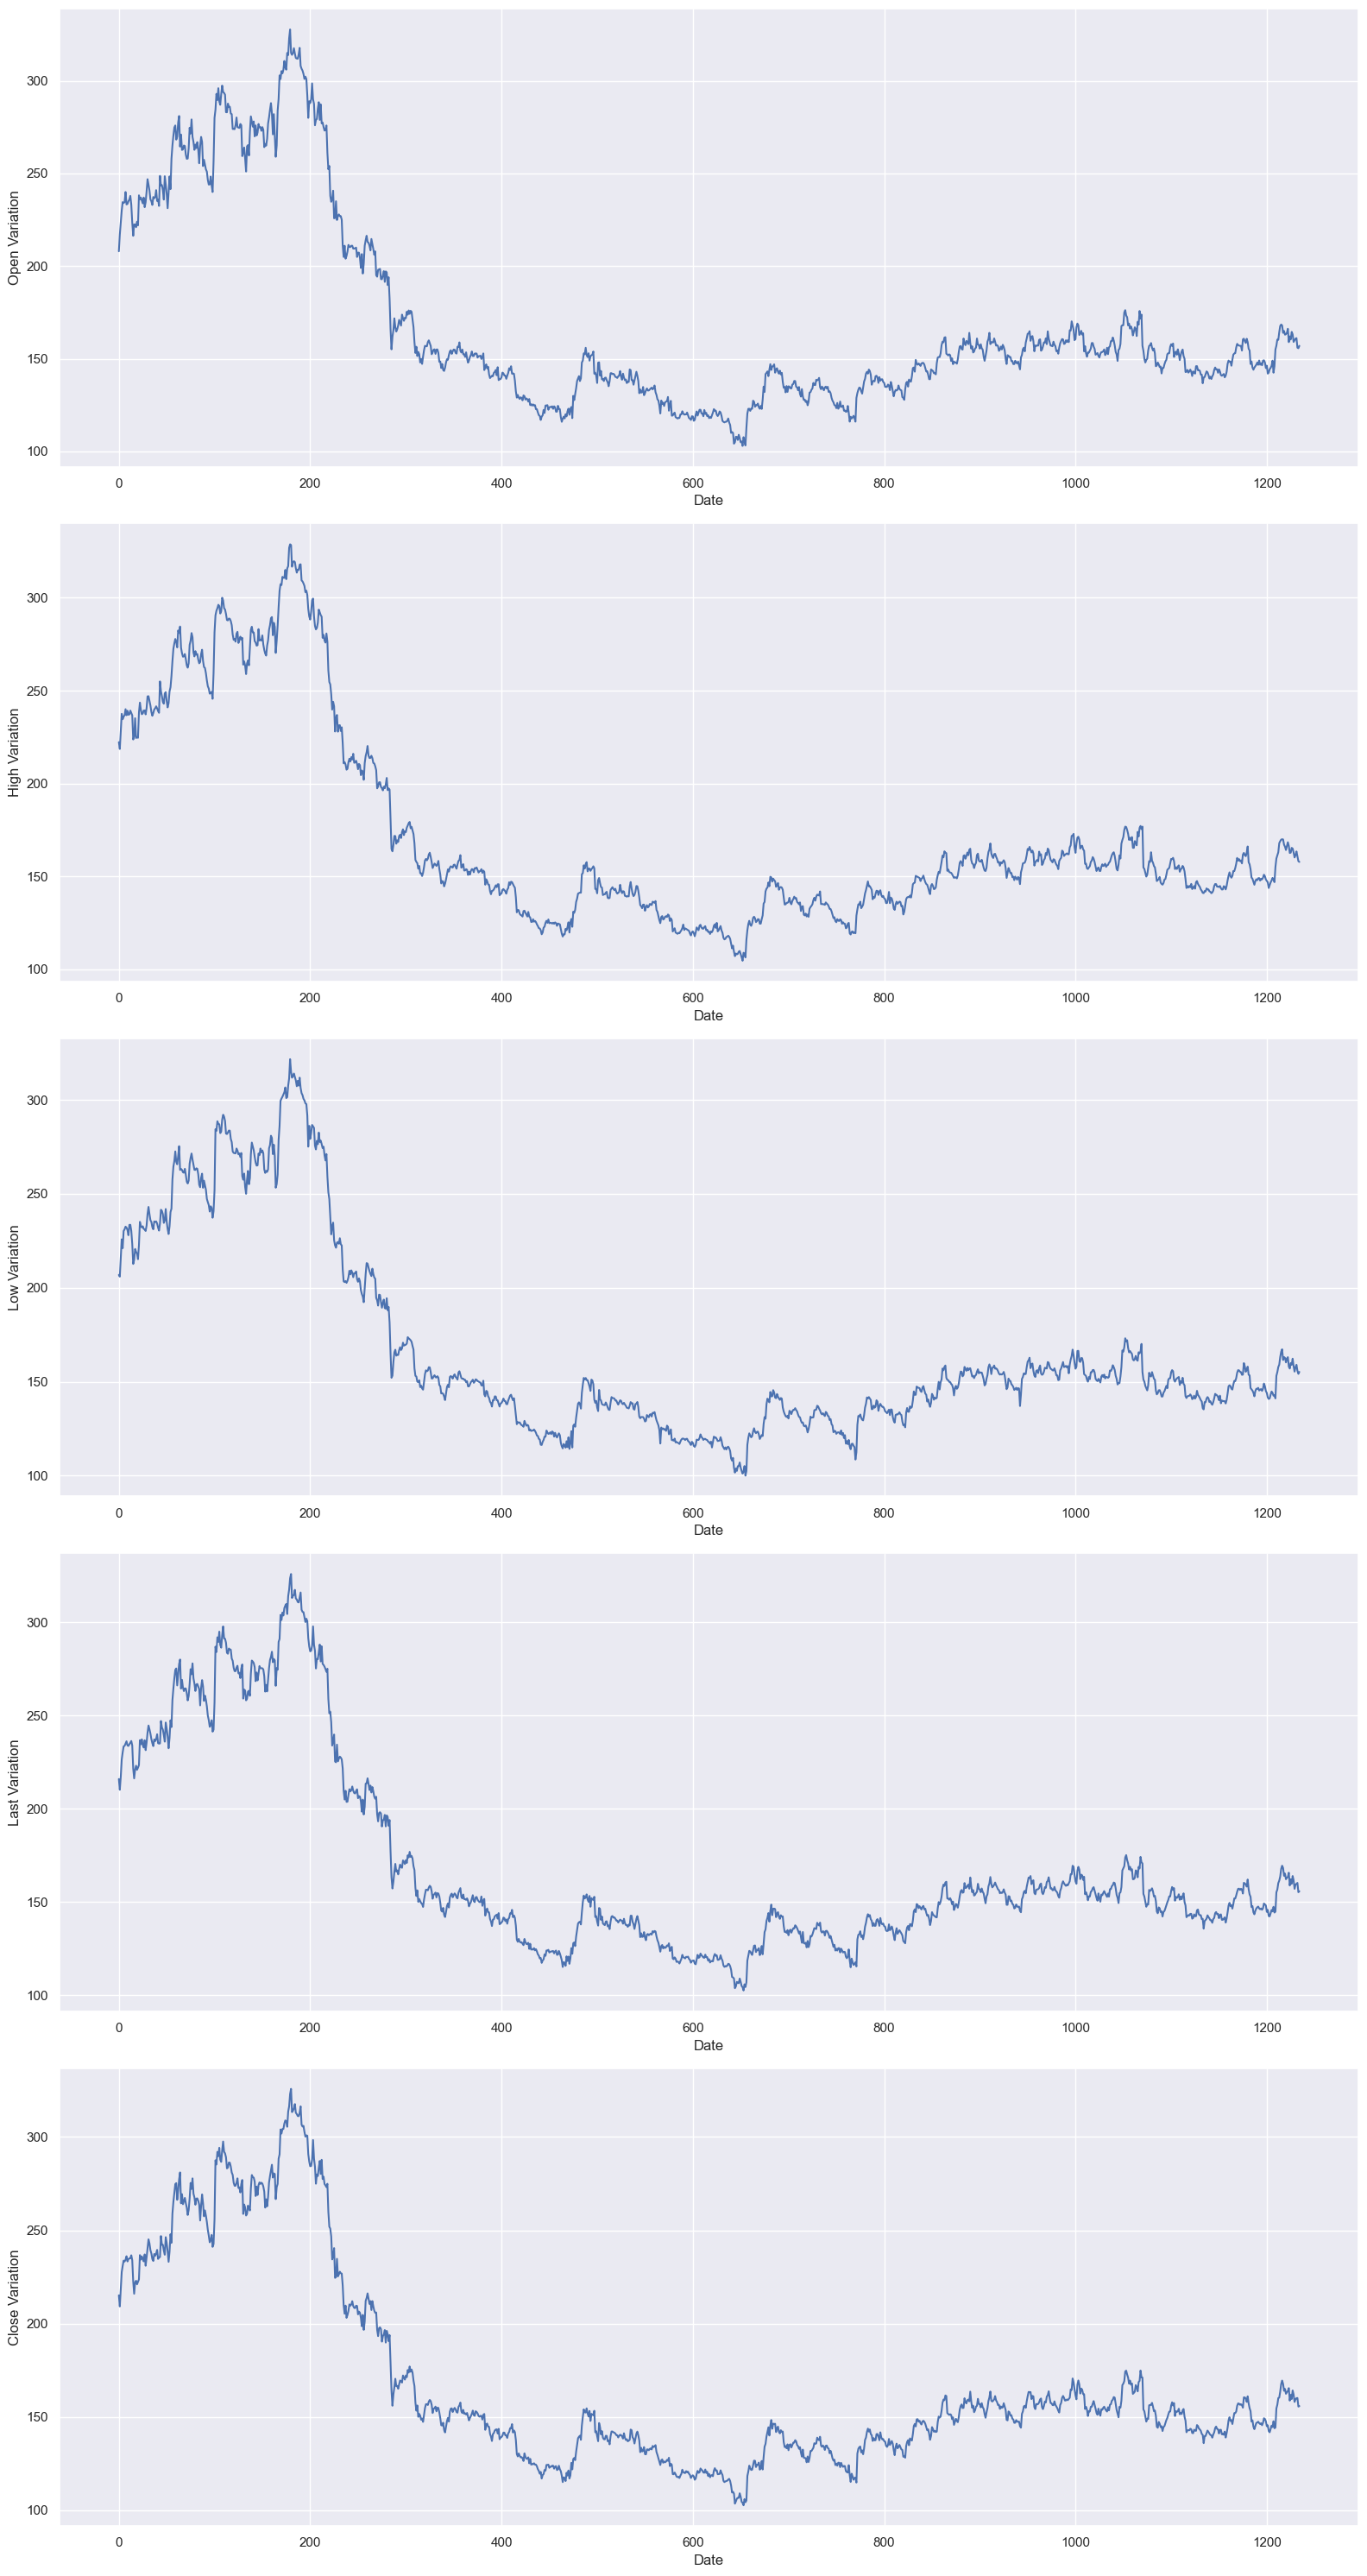

In [187]:
cols_plot=['Open','High','Low','Last','Close']
fig,axes=plt.subplots(nrows=len(cols_plot),figsize=(16,6*len(cols_plot)))

for i, col in enumerate(cols_plot):
    df[col].plot(ax=axes[i], alpha=1)
    axes[i].set_ylabel(col + ' Variation')
    axes[i].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [188]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df["Date"]

In [189]:
df.index

DatetimeIndex(['2018-10-08', '2018-10-05', '2018-10-04', '2018-10-03',
               '2018-10-01', '2018-09-28', '2018-09-27', '2018-09-26',
               '2018-09-25', '2018-09-24',
               ...
               '2013-10-22', '2013-10-21', '2013-10-18', '2013-10-17',
               '2013-10-15', '2013-10-14', '2013-10-11', '2013-10-10',
               '2013-10-09', '2013-10-08'],
              dtype='datetime64[ns]', name='Date', length=1235, freq=None)

In [190]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-10-08,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


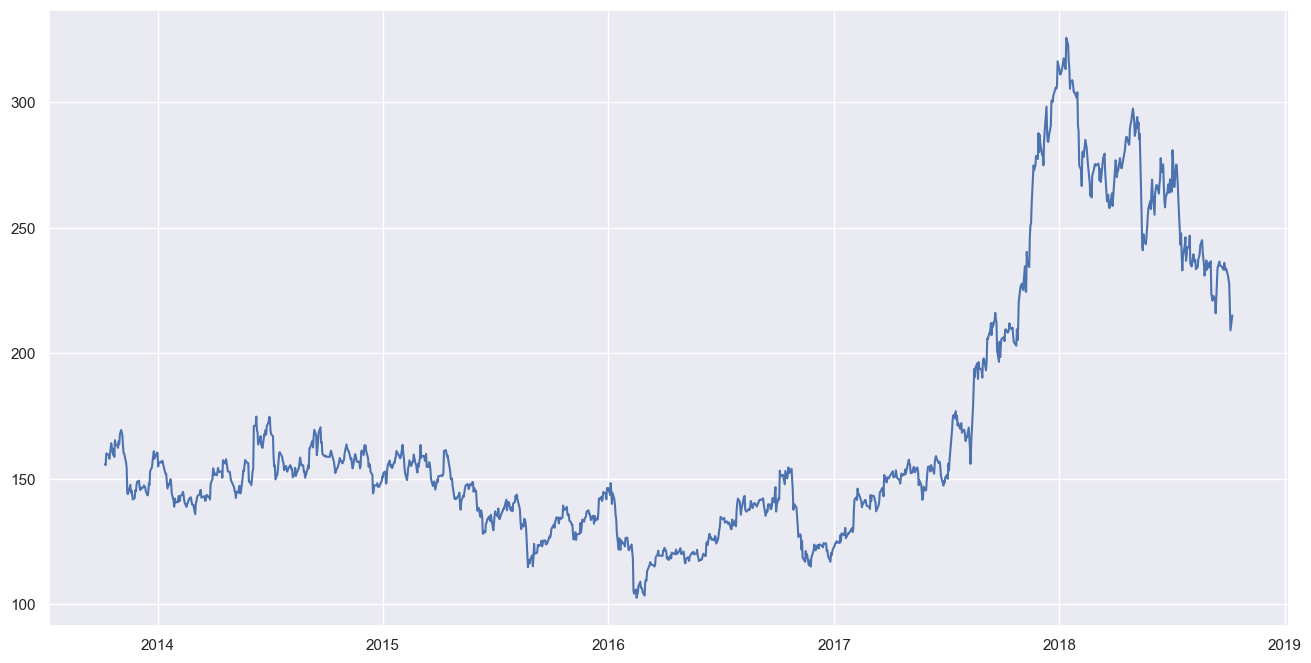

In [191]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [192]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [193]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

In [194]:
data

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2013-10-08,2013-10-08,157.00,157.80,155.20,155.80,155.80,1720413.0,2688.94
2013-10-09,2013-10-09,155.70,158.20,154.15,155.30,155.55,2049580.0,3204.49
2013-10-10,2013-10-10,156.00,160.80,155.85,160.30,160.15,3124853.0,4978.80
2013-10-11,2013-10-11,161.15,163.45,159.00,159.80,160.05,1880046.0,3030.76
2013-10-14,2013-10-14,160.85,161.45,157.70,159.30,159.45,1281419.0,2039.09
...,...,...,...,...,...,...,...,...
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79


In [195]:
new_dataset = data[['Date', 'Close']].copy()
new_dataset.tail()

,Date,Close
Date,,
2018-10-01,2018-10-01,230.90
2018-10-03,2018-10-03,227.60
2018-10-04,2018-10-04,218.20
2018-10-05,2018-10-05,209.20
2018-10-08,2018-10-08,215.15


In [196]:
new_dataset.head()


,Date,Close
Date,,
2013-10-08,2013-10-08,155.80
2013-10-09,2013-10-09,155.55
2013-10-10,2013-10-10,160.15
2013-10-11,2013-10-11,160.05
2013-10-14,2013-10-14,159.45


In [197]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [198]:
new_dataset.head()

,Close
Date,
2013-10-08,155.80
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


In [199]:
final_dataset=new_dataset.values

In [200]:
final_dataset
# len(final_dataset)

array([[155.8 ],
       [155.55],
       [160.15],
       ...,
       [218.2 ],
       [209.2 ],
       [215.15]])

In [201]:
len(final_dataset)

1235

In [202]:
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

In [205]:
len(train_data)


987

In [204]:
len(valid_data)

248

In [203]:
len(train_data) + len(valid_data) == len(final_dataset)

True

In [206]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [207]:
scaled_data
# len(scaled_data)

array([[0.23823398],
       [0.2371134 ],
       [0.25773196],
       ...,
       [0.51792918],
       [0.47758853],
       [0.50425818]])

In [208]:
x_train_data,y_train_data=[],[]

In [209]:
scaled_data[0:60,0]


array([0.23823398, 0.2371134 , 0.25773196, 0.25728373, 0.25459435,
       0.24831914, 0.2660242 , 0.27588525, 0.2552667 , 0.26535186,
       0.25145675, 0.28148812, 0.27431645, 0.27162707, 0.26781712,
       0.27947109, 0.27498879, 0.29157329, 0.29964142, 0.29112506,
       0.27297176, 0.25862842, 0.25750784, 0.2415957 , 0.23263111,
       0.18668758, 0.18511878, 0.20192739, 0.18780816, 0.19139399,
       0.18377409, 0.17548185, 0.17817122, 0.19206634, 0.19004931,
       0.20170327, 0.20730614, 0.20909906, 0.19789332, 0.19229045,
       0.19722098, 0.19520394, 0.19744509, 0.20080681, 0.19878978,
       0.19766921, 0.19049753, 0.18287763, 0.18870462, 0.20416853,
       0.20103093, 0.22613178, 0.23330345, 0.2447333 , 0.26176602,
       0.24831914, 0.25616316, 0.25907665, 0.25930076, 0.23442403])

In [210]:
scaled_data[120,0]

0.21246077991931872

In [211]:
len(scaled_data[0:60,0])

60

In [212]:
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

In [213]:
x_train_data

[array([0.23823398, 0.2371134 , 0.25773196, 0.25728373, 0.25459435,
        0.24831914, 0.2660242 , 0.27588525, 0.2552667 , 0.26535186,
        0.25145675, 0.28148812, 0.27431645, 0.27162707, 0.26781712,
        0.27947109, 0.27498879, 0.29157329, 0.29964142, 0.29112506,
        0.27297176, 0.25862842, 0.25750784, 0.2415957 , 0.23263111,
        0.18668758, 0.18511878, 0.20192739, 0.18780816, 0.19139399,
        0.18377409, 0.17548185, 0.17817122, 0.19206634, 0.19004931,
        0.20170327, 0.20730614, 0.20909906, 0.19789332, 0.19229045,
        0.19722098, 0.19520394, 0.19744509, 0.20080681, 0.19878978,
        0.19766921, 0.19049753, 0.18287763, 0.18870462, 0.20416853,
        0.20103093, 0.22613178, 0.23330345, 0.2447333 , 0.26176602,
        0.24831914, 0.25616316, 0.25907665, 0.25930076, 0.23442403]),
 array([0.2371134 , 0.25773196, 0.25728373, 0.25459435, 0.24831914,
        0.2660242 , 0.27588525, 0.2552667 , 0.26535186, 0.25145675,
        0.28148812, 0.27431645, 0.27162707, 0.

In [214]:
y_train_data

[0.24069923800986098,
 0.24271627073061414,
 0.24137158225011207,
 0.2440609592111161,
 0.24473330345136707,
 0.23890632003585827,
 0.22523532048408784,
 0.2214253697893322,
 0.2214253697893322,
 0.20797848498431198,
 0.19520394441954275,
 0.204616763783057,
 0.20259973106230383,
 0.2115643209323173,
 0.20416853428955622,
 0.18646346929627972,
 0.17346481398476016,
 0.16270730614074397,
 0.1770506499327656,
 0.16943074854325407,
 0.17189601075750777,
 0.1705513222770057,
 0.18153294486777233,
 0.18108471537427168,
 0.17256835499775885,
 0.18242940385477363,
 0.18354997758852526,
 0.18915284625728362,
 0.1855670103092784,
 0.17525773195876287,
 0.16987897803675484,
 0.16248319139399375,
 0.16831017480950244,
 0.16898251904975342,
 0.17234424025100842,
 0.1763783056925145,
 0.17951591214701917,
 0.17279246974450907,
 0.16651725683549984,
 0.16606902734199908,
 0.14926042133572387,
 0.16920663379650386,
 0.17144778126400723,
 0.1788435679067683,
 0.1822052891080233,
 0.18444643657552667,


In [216]:
len(x_train_data)

927

In [217]:
len(y_train_data)

927

In [218]:
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)


In [219]:
x_train_data

array([[0.23823398, 0.2371134 , 0.25773196, ..., 0.25907665, 0.25930076,
        0.23442403],
       [0.2371134 , 0.25773196, 0.25728373, ..., 0.25930076, 0.23442403,
        0.24069924],
       [0.25773196, 0.25728373, 0.25459435, ..., 0.23442403, 0.24069924,
        0.24271627],
       ...,
       [0.24697445, 0.28641865, 0.29964142, ..., 0.45047064, 0.46234872,
        0.46526221],
       [0.28641865, 0.29964142, 0.31869117, ..., 0.46234872, 0.46526221,
        0.45853877],
       [0.29964142, 0.31869117, 0.32608696, ..., 0.46526221, 0.45853877,
        0.4787091 ]])

In [220]:
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [221]:
x_train_data

array([[[0.23823398],
        [0.2371134 ],
        [0.25773196],
        ...,
        [0.25907665],
        [0.25930076],
        [0.23442403]],

       [[0.2371134 ],
        [0.25773196],
        [0.25728373],
        ...,
        [0.25930076],
        [0.23442403],
        [0.24069924]],

       [[0.25773196],
        [0.25728373],
        [0.25459435],
        ...,
        [0.23442403],
        [0.24069924],
        [0.24271627]],

       ...,

       [[0.24697445],
        [0.28641865],
        [0.29964142],
        ...,
        [0.45047064],
        [0.46234872],
        [0.46526221]],

       [[0.28641865],
        [0.29964142],
        [0.31869117],
        ...,
        [0.46234872],
        [0.46526221],
        [0.45853877]],

       [[0.29964142],
        [0.31869117],
        [0.32608696],
        ...,
        [0.46526221],
        [0.45853877],
        [0.4787091 ]]])

In [222]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))


In [223]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 21s - loss: 0.0015 - 21s/epoch - 23ms/step


In [224]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [225]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [226]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

In [227]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

8/8 [==============================] - 1s 20ms/step


In [228]:
lstm_model.save("data/saved_lstm_model.h5")

c:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\parme\AppData\Local\Temp\ipykernel_15968\4128311284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


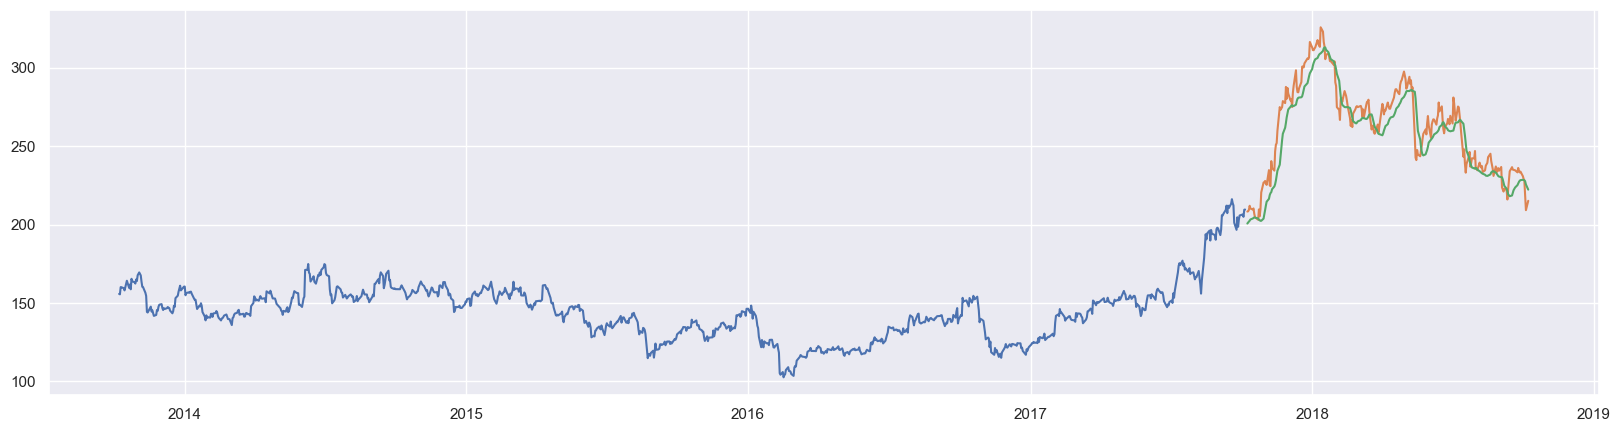

In [229]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])